# Стохастический градиентный спуск с ускорением

В предыдущих ноутбуках я написал код для [Batch Gradient Descent](https://github.com/konstantin-suspitsyn/algorithms-from-scratch/blob/main/basic_gd_milti_variables.ipynb)<br><br>Продолжим далее, описывать алгоритмы. На этот раз, я буду использовать список алгоритмов из документа [An overview of gradient descent optimizationalgorithms](https://arxiv.org/pdf/1609.04747.pdf). Одно из основных условий — использовать по минимому готовых математических алгоритмов (умножкение вектор на вектор, матрица на вектор и т. д.)

## Теория

Стохастический градиентный спуск с ускорением строится на стохастическом градиентном спуске. В него подается случайная строка из известных в данных для обучения и вся работа по вычислению градиента ведется по одной строке. Потом переходят к следующей случайной строке. Это долго, поэтому придумали ускорение

Очень интересно, но я нашел 2 вида формул в разных статьях:<br>
1. [An overview of gradient descent optimization algorithms](https://arxiv.org/pdf/1609.04747.pdf):<br>
$v_t = \gamma * v_{t-1} + \alpha \nabla_\theta f(\theta)$<br>
$\theta = \theta - v_t$
2. [An Improved Analysis of Stochastic Gradient Descentwith Momentum](https://arxiv.org/pdf/2007.07989.pdf):<br>
$v_t = \gamma * v_{t-1} + (1-\gamma) \nabla_\theta f(\theta)$<br>
$\theta = \theta - \alpha v_t$<br>
Где: <br>$\nabla_\theta f(\theta)$ - частная производная по $\theta$<br>
$\gamma$ - вес ускорения. $\gamma \in [0,1)$<br>
$\alpha$ - learning rate (шаг сдвига)

Реализую оба и посмотрим где MSE меньше после одинакового количества шагов

Берем старый класс. Из него мы будем использовать функции progress_tracker и mse_function

In [ ]:
class GradientDescents:
  
  '''
  Имплементация градиентного спуска с нуля
  '''

  import random

  def progress_tracker(self, step: int, cost_function: float) -> None:
    '''
    Функция позволяет отслеживать онлайн прогресс

    :param step: текущий шаг
    :param cost_function: значение кост-функции в данный момент

    '''
    from IPython.display import clear_output
    clear_output(wait=True)
    print('Шаг: {}'.format(step))
    print('Функция потерь: {:.2f}'.format(cost_function))

  def mse_function(self, y_true: list, y_pred: list) -> float:
    '''
    Функция, которая считет MSE

    :param y_true: значения y, которые мы знаем из фактических данных
    :param y_pred: значения y, которые мы получили в данный момент

    :return mse: значеник MSE по формуле
    '''
    # Кол-во значений, которое мы сравнивам
    n = len(y_true)
    # Стартуем с нуля
    pre_mse = 0
    for index, value in enumerate(y_true):
      pre_mse += (value - y_pred[index])**2
    mse = pre_mse/n
    return mse

  def gradient_descent_multi(self, X_true: list, y_true: list, \
                              weights: list = None, max_steps: int = 10000, \
                              learning_rate: float = 0.003, \
                              save_steps: int = 0) -> dict:
    '''
    Градиентный спуск для нескольких переменных

    :param X_true: фактические аттрибуты
    :param y_true: фактические результаты
    :param weights: стартовые веса, если не хотим начать обучение с рандома
    :param learning_rate: коэффициент обучения
    :param max_steps: максимальное кол-во шагов, при которых алгоритм остановится
    :param save_steps: если 0, сохранится только последний шаг
                        если значение отличное от нуля, 
                        будет сохраняться каждый i-ый шаг
    
    :return {
      :return weights: веса регресси
      :return mse: значение MSE
      :return steps: количество шагов
      :return mse_list: значение MSE во вреия обучения, если save_steps > 0
      :return weights_list: веса по мере обучения, если save_steps > 0
    }
    '''

    # Код для данных с 1 аттрибутом
    if (type(X_true[0])==int) or (type(X_true[0])==float):
      for i, x in enumerate(X_true):
        X_true[i]=[x,1]
    elif (type(X_true[0])==list) and (len(X_true[0])==1):
      for i, x in enumerate(X_true):
        X_true[i].append(1)

    # Создаем рандомный спиок весов данных равный количеству атрибутов
    if weights == None:
      weights = [self.random.random() for f in X_true[0]]

    if save_steps > 0:
      mse_list = []
      weights_list = []
    
    # MSE предыдущего шага
    mse_prev = 0
    mse = 999

    # Кол-во экспериментов, которые у нас есть      
    n = len(X_true)

    step = 0
    while (step <= max_steps) and (abs(mse_prev-mse)>1e-5):
      # Считаем градиенты
      gradients = []
      for wi, w_value in enumerate(weights):
        current_gradient=0
        for yi, y_t_val in enumerate(y_true):
          current_gradient += -2*(y_t_val - sum([w*x for w,x in \
                                                 zip(weights,X_true[yi])]))* X_true[yi][wi]
        current_gradient = current_gradient/n
        gradients.append(current_gradient)

      # Делаем сдвиг весов
      for gi, gr_value in enumerate(gradients):
        weights[gi] = weights[gi] - learning_rate*gr_value

      #Считаем y_pred
      y_pred = []
      for X_current in X_true:
        y_pred.append(sum([w*x for w,x in zip(weights,X_current)]))
      
      step +=1
      mse_prev = mse
      mse = self.mse_function(y_true, y_pred)
      self.progress_tracker(step, mse)

      if save_steps > 0:
        if step % save_steps == 0:
          mse_list.append(mse)
          weights_list.append(weights)

    if save_steps > 0:
      return_dict = {'weights': weights, 'mse':mse, 'steps': step-1, \
                      'mse_list': mse_list, 'weights_list': weights_list}
    else:
      return_dict = {'weights': weights, 'mse':mse, 'steps': step-1}

    return return_dict

In [ ]:
new_grad = GradientDescents()

Реализуем
1. [An overview of gradient descent optimization algorithms](https://arxiv.org/pdf/1609.04747.pdf):<br>
$v_t = \gamma * v_{t-1} + \alpha \nabla_\theta f(\theta)$<br>
$\theta = \theta - v_t$

In [ ]:
import random

In [ ]:
# Загрузим данные из Boston Dataset
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
X_true = []
for i in X:
  x_s_list = [f for f in i]
  # x_s_list.append(1)
  X_true.append(x_s_list)
y_true = [f for f in y]
del X, y

In [ ]:
learning_rate = 0.0000003
max_steps = 50000
step = 0

# Ускорение
gamma = 0.5

# Для чистоты выбора алгоритма, я буду стартовать веса с 1
weights = [1] * len(X_true[0])

# Кол-во элементов в строке X
n = len(X_true[0])

# Стартуем градиенты
# Текущий градиент
gradient = []
# Предыдущий сдвиг
v_t_previous = [0] * len(X_true[0])

all_mses_algo1 = []

while step < max_steps:
  # Для чистоты эксперимента, каждый рандом будет равен step
  random.seed(step)
  # Берем номер для выбора данных
  index = random.randint(0, n-1)
  # X и y текущего шага
  X_current = X_true[index]
  y_current = y_true[index]
  gradient = []
  # Вычисляем текущий градиента
  for x_i in X_current:
    current_gradient = -2*(y_current - sum([w*x for w,x in \
                                          zip(weights,X_current)]))*x_i
    gradient.append(current_gradient)
  
  # Применяем ускорение к предыдущему сдвигу
  momentum_v_t_previous = [f*gamma for f in v_t_previous]
  # Применяем шаг к градиенту
  step_gradient = [f*learning_rate for f in gradient]
  # Получаем новый сдвиг
  v_t = [a+b for a,b in zip(momentum_v_t_previous,step_gradient)]
  # В предыдущий сдвиг записываем новый
  v_t_previous = v_t

  # Делаем сдвиг весов
  for vti, vti_value in enumerate(v_t):
    weights[vti] = weights[vti] - vti_value

  y_pred = sum([w*x for w,x in zip(weights,X_current)])
  mse = new_grad.mse_function([y_pred], [y_current])

  step += 1

  new_grad.progress_tracker(step, mse)

  # Последим за прогрессом
  y_pred_algo_1 = []
  for X_current in X_true:
    y_pred_algo_1.append(sum([w*x for w,x in zip(weights,X_current)]))

  mse_algo_1 = new_grad.mse_function(y_pred_algo_1, y_true)


  all_mses_algo1.append(mse_algo_1)


Шаг: 50000
Функция потерь: 5.41


Посчитаем общий MSE

Реализуем
2. [An Improved Analysis of Stochastic Gradient Descentwith Momentum](https://arxiv.org/pdf/2007.07989.pdf):<br>
$v_t = \gamma * v_{t-1} + (1-\gamma) \nabla_\theta f(\theta)$<br>
$\theta = \theta - \alpha v_t$<br>

In [ ]:
learning_rate = 0.0000003
max_steps = 50000
step = 0

# Ускорение
gamma = 0.9

# Для чистоты выбора алгоритма, я буду стартовать веса с 1
weights = [1] * len(X_true[0])

# Кол-во элементов в строке X
n = len(X_true[0])

# Стартуем градиенты
# Текущий градиент
gradient = []
# Предыдущий сдвиг
v_t_previous = [0] * len(X_true[0])
all_mses_algo2 = []
while step < max_steps:
  # Для чистоты эксперимента, каждый рандом будет равен step
  random.seed(step)
  # Берем номер для выбора данных
  index = random.randint(0, n-1)
  # X и y текущего шага
  X_current = X_true[index]
  y_current = y_true[index]
  gradient = []
  # Вычисляем текущий градиента
  for x_i in X_current:
    current_gradient = -2*(y_current - sum([w*x for w,x in \
                                          zip(weights,X_current)]))*x_i
    gradient.append(current_gradient)
  
  # Применяем ускорение к предыдущему сдвигу
  momentum_v_t_previous = [f*gamma for f in v_t_previous]
  # Применяем шаг к градиенту
  step_gradient = [f*(1-gamma) for f in gradient]
  # Получаем новый сдвиг
  v_t = [a+b for a,b in zip(momentum_v_t_previous,step_gradient)]
  # В предыдущий сдвиг записываем новый
  v_t_previous = v_t

  # Делаем сдвиг весов
  for vti, vti_value in enumerate(v_t):
    weights[vti] = weights[vti] - vti_value * learning_rate

  y_pred = sum([w*x for w,x in zip(weights,X_current)])
  mse = new_grad.mse_function([y_pred], [y_current])

  step += 1

  new_grad.progress_tracker(step, mse)

  # Последим за прогрессом
  y_pred_algo_2 = []
  for X_current in X_true:
    y_pred_algo_2.append(sum([w*x for w,x in zip(weights,X_current)]))

  mse_algo_2 = new_grad.mse_function(y_pred_algo_2, y_true)

  all_mses_algo2.append(mse_algo_2)



Шаг: 50000
Функция потерь: 16.88


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
steps = [i+1 for i, f in enumerate(all_mses_algo2)]

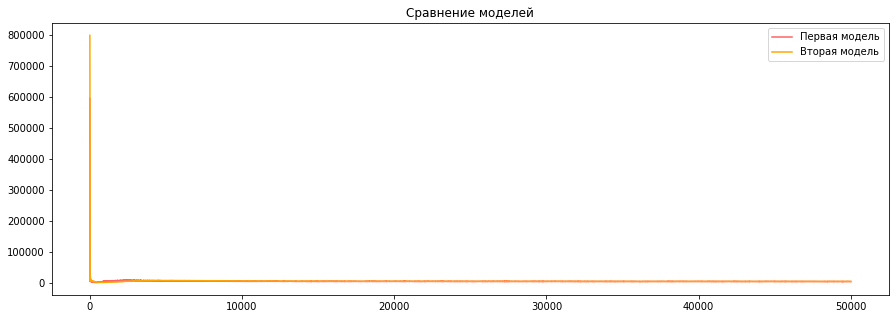

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(steps, all_mses_algo1, color='#ff6361', \
        label='Первая модель')
plt.plot(steps, all_mses_algo2, color='#ffa600', \
         label='Вторая модель')
plt.title('Сравнение моделей')
ax.legend()
plt.show()

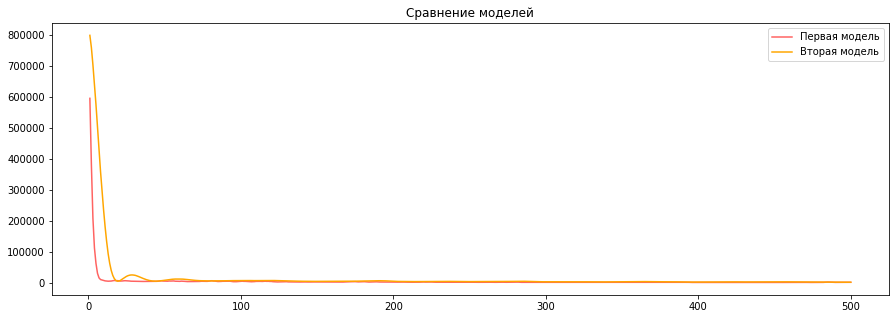

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(steps[:500], all_mses_algo1[:500], color='#ff6361', \
        label='Первая модель')
plt.plot(steps[:500], all_mses_algo2[:500], color='#ffa600', \
         label='Вторая модель')
plt.title('Сравнение моделей')
ax.legend()
plt.show()

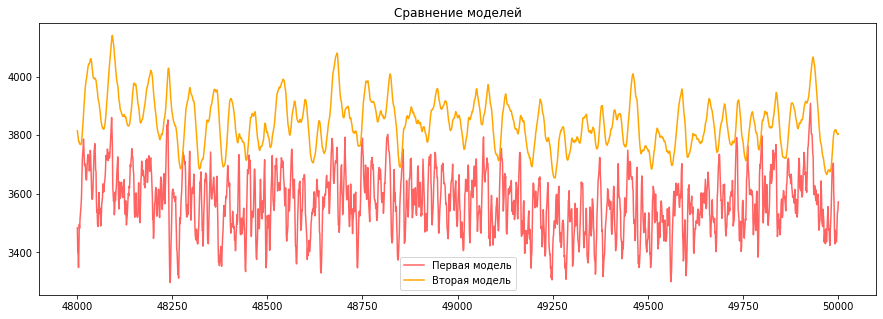

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(steps[-2000:], all_mses_algo1[-2000:], color='#ff6361', \
        label='Первая модель')
plt.plot(steps[-2000:], all_mses_algo2[-2000:], color='#ffa600', \
         label='Вторая модель')
plt.title('Сравнение моделей')
ax.legend()
plt.show()

Тесты показывают, что первая модель эффективнее. Ее и положим в класс

# Финальный класс

In [ ]:
class GradientDescents:
  
  '''
  Имплементация градиентного спуска с нуля
  '''

  import random

  def progress_tracker(self, step: int, cost_function: float) -> None:
    '''
    Функция позволяет отслеживать онлайн прогресс

    :param step: текущий шаг
    :param cost_function: значение кост-функции в данный момент

    '''
    from IPython.display import clear_output
    clear_output(wait=True)
    print('Шаг: {}'.format(step))
    print('Функция потерь: {:.2f}'.format(cost_function))

  def mse_function(self, y_true: list, y_pred: list) -> float:
    '''
    Функция, которая считет MSE

    :param y_true: значения y, которые мы знаем из фактических данных
    :param y_pred: значения y, которые мы получили в данный момент

    :return mse: значеник MSE по формуле
    '''
    # Кол-во значений, которое мы сравнивам
    n = len(y_true)
    # Стартуем с нуля
    pre_mse = 0
    for index, value in enumerate(y_true):
      pre_mse += (value - y_pred[index])**2
    mse = pre_mse/n
    return mse

  def gradient_descent_multi(self, X_true: list, y_true: list, \
                              weights: list = None, max_steps: int = 10000, \
                              learning_rate: float = 0.003, \
                              save_steps: int = 0) -> dict:
    '''
    Градиентный спуск для нескольких переменных

    :param X_true: фактические аттрибуты
    :param y_true: фактические результаты
    :param weights: стартовые веса, если не хотим начать обучение с рандома
    :param learning_rate: коэффициент обучения
    :param max_steps: максимальное кол-во шагов, при которых алгоритм остановится
    :param save_steps: если 0, сохранится только последний шаг
                        если значение отличное от нуля, 
                        будет сохраняться каждый i-ый шаг

    :return {
      :return weights: веса регресси
      :return mse: значение MSE
      :return steps: количество шагов
      :return mse_list: значение MSE во вреия обучения, если save_steps > 0
      :return weights_list: веса по мере обучения, если save_steps > 0
    }
    
    '''

    # Код для данных с 1 аттрибутом
    if (type(X_true[0])==int) or (type(X_true[0])==float):
      for i, x in enumerate(X_true):
        X_true[i]=[x,1]
    elif (type(X_true[0])==list) and (len(X_true[0])==1):
      for i, x in enumerate(X_true):
        X_true[i].append(1)

    # Создаем рандомный спиок весов данных равный количеству атрибутов
    if weights == None:
      weights = [self.random.random() for f in X_true[0]]

    if save_steps > 0:
      mse_list = []
      weights_list = []
    
    # MSE предыдущего шага
    mse_prev = 0
    mse = 999

    # Кол-во экспериментов, которые у нас есть      
    n = len(X_true)

    step = 0
    while (step <= max_steps) and (abs(mse_prev-mse)>1e-5):
      # Считаем градиенты
      gradients = []
      for wi, w_value in enumerate(weights):
        current_gradient=0
        for yi, y_t_val in enumerate(y_true):
          current_gradient += -2*(y_t_val - sum([w*x for w,x in \
                                                 zip(weights,X_true[yi])]))* X_true[yi][wi]
        current_gradient = current_gradient/n
        gradients.append(current_gradient)

      # Делаем сдвиг весов
      for gi, gr_value in enumerate(gradients):
        weights[gi] = weights[gi] - learning_rate*gr_value

      #Считаем y_pred
      y_pred = []
      for X_current in X_true:
        y_pred.append(sum([w*x for w,x in zip(weights,X_current)]))
      
      step +=1
      mse_prev = mse
      mse = self.mse_function(y_true, y_pred)
      self.progress_tracker(step, mse)

      if save_steps > 0:
        if step % save_steps == 0:
          mse_list.append(mse)
          weights_list.append(weights)

    if save_steps > 0:
      return_dict = {'weights': weights, 'mse':mse, 'steps': step-1, \
                      'mse_list': mse_list, 'weights_list': weights_list}
    else:
      return_dict = {'weights': weights, 'mse':mse, 'steps': step-1}

    return return_dict

  def momentum_gradient_descent(self, X_true: list, y_true: list, \
                                weights: list = None, max_steps: int = 10000, \
                                learning_rate: float = 0.003, gamma: float = 0.9, \
                                save_steps: int = 0) -> dict:
    '''
    Градиентный спуск с ускорением

    :param X_true: фактические аттрибуты
    :param y_true: фактические результаты
    :param weights: стартовые веса, если не хотим начать обучение с рандома
    :param learning_rate: коэффициент обучения
    :param max_steps: максимальное кол-во шагов, при которых алгоритм остановится
    :param save_steps: если 0, сохранится только последний шаг
                        если значение отличное от нуля, 
                        будет сохраняться каждый i-ый шаг

    :return {
      :return weights: веса регресси
      :return mse: значение MSE
      :return steps: количество шагов
      :return mse_list: значение MSE во вреия обучения, если save_steps > 0
      :return weights_list: веса по мере обучения, если save_steps > 0
    }
                      
    '''
    # Код для данных с 1 аттрибутом
    if (type(X_true[0])==int) or (type(X_true[0])==float):
      for i, x in enumerate(X_true):
        X_true[i]=[x,1]
    elif (type(X_true[0])==list) and (len(X_true[0])==1):
      for i, x in enumerate(X_true):
        X_true[i].append(1)


    if save_steps > 0:
      mse_list = []
      weights_list = []

    step = 0
    mse_prev = 999999999


    # Для чистоты выбора алгоритма, я буду стартовать веса с 1
    if weights == None:
      weights = [self.random.random() for f in X_true[0]]

    # Кол-во элементов в строке X
    n = len(X_true[0])

    # Стартуем градиенты
    # Текущий градиент
    gradient = []
    # Предыдущий сдвиг
    v_t_previous = [0] * len(X_true[0])
    
    # TO DO: По-хорошему, надо написать условие по тестовой выборке
    while step < max_steps:

      # Берем номер для выбора данных
      index = self.random.randint(0, n-1)
      # X и y текущего шага
      X_current = X_true[index]
      y_current = y_true[index]
      gradient = []
      # Вычисляем текущий градиента
      for x_i in X_current:
        current_gradient = -2*(y_current - sum([w*x for w,x in \
                                              zip(weights,X_current)]))*x_i
        gradient.append(current_gradient)
      
      # Применяем ускорение к предыдущему сдвигу
      momentum_v_t_previous = [f*gamma for f in v_t_previous]
      # Применяем шаг к градиенту
      step_gradient = [f*learning_rate for f in gradient]
      # Получаем новый сдвиг
      v_t = [a+b for a,b in zip(momentum_v_t_previous,step_gradient)]
      # В предыдущий сдвиг записываем новый
      v_t_previous = v_t

      # Делаем сдвиг весов
      for vti, vti_value in enumerate(v_t):
        weights[vti] = weights[vti] - vti_value

      y_pred = sum([w*x for w,x in zip(weights,X_current)])

      y_pred_algo = []
      for X_current in X_true:
        y_pred_algo.append(sum([w*x for w,x in zip(weights,X_current)]))

      
      mse = self.mse_function(y_pred_algo, y_true)

      if mse < mse_prev:
        # Сохраняю только лучший результат
        # Опять же mse правильнее было бы считать на тестовых данных
        final_weights = weights

      mse_prev = mse

      step += 1

      self.progress_tracker(step, mse)

      if save_steps > 0:
        if step % save_steps == 0:
          mse_list.append(mse)
          weights_list.append(weights)

    if save_steps > 0:
      return_dict = {'weights': final_weights, 'mse':mse, 'steps': step-1, \
                      'mse_list': mse_list, 'weights_list': weights_list}
    else:
      return_dict = {'weights': final_weights, 'mse':mse, 'steps': step-1}

    return return_dict

## Тест на Boston Dataset

In [ ]:
# Загрузим данные из Boston Dataset
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
X_true = []
for i in X:
  x_s_list = [f for f in i]
  # x_s_list.append(1)
  X_true.append(x_s_list)
y_true = [f for f in y]
del X, y

In [ ]:
msgd = GradientDescents()

In [ ]:
gd = msgd.momentum_gradient_descent(X_true, y_true, learning_rate=0.000003, max_steps=1000)

Шаг: 1000
Функция потерь: 3815.04


In [ ]:
y_pred_algo_1 = []
for X_current in X_true:
  y_pred_algo_1.append(sum([w*x for w,x in zip(gd['weights'],X_current)]))

mse_algo_1 = msgd.mse_function(y_pred_algo_1, y_true)

In [ ]:
gd_next = msgd.momentum_gradient_descent(X_true, y_true, learning_rate=0.000003, max_steps=10000,\
                                         weights = gd['weights'])

Шаг: 10000
Функция потерь: 1013.34


In [ ]:
y_pred_algo_2 = []
for X_current in X_true:
  y_pred_algo_2.append(sum([w*x for w,x in zip(gd_next['weights'],X_current)]))

mse_algo_2 = msgd.mse_function(y_pred_algo_2, y_true)

In [ ]:
mse_algo_1

3815.0380628428316

In [ ]:
mse_algo_2

1013.3435556810301

In [ ]:
gd_next = msgd.momentum_gradient_descent(X_true, y_true, learning_rate=0.000003, max_steps=50000,\
                                         weights = gd_next['weights'])

Шаг: 50000
Функция потерь: 963.54


In [ ]:
y_pred_algo_3 = []
for X_current in X_true:
  y_pred_algo_3.append(sum([w*x for w,x in zip(gd_next['weights'],X_current)]))

mse_algo_3 = msgd.mse_function(y_pred_algo_3, y_true)

In [ ]:
mse_algo_3

963.5357397887992

Конечно, правильнее было бы считать MSE на тестовом датасете, но мы видим, что результат улучшается по мере обучения